<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Classification Exercises

The following is a template for 02. PyTorch Classification exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

## Resources
* These exercises are based on [notebook 02 of the learn PyTorch course](https://www.learnpytorch.io/02_pytorch_classification/).
* You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [1]:
# Import torch
import torch
from torch.xpu import device

# Setup device agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu"))

# Setup random seed
RANDOM_SEED = 42

In [2]:
device

device(type='mps')

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors. 
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [3]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, shuffle=True, noise=0.25, random_state=RANDOM_SEED)
X[:,0].shape, y.shape

((1000,), (1000,))

In [4]:
X[:10], y[:10]

(array([[-0.14176498,  0.55823629],
        [ 1.19796627, -0.30399544],
        [ 0.759391  ,  0.1102501 ],
        [ 0.02331452, -0.60356298],
        [-0.80797972,  0.54846574],
        [ 0.68691218, -0.00534917],
        [ 0.26851706, -0.1842172 ],
        [-0.14528157,  0.56532837],
        [ 1.5564451 , -0.35139996],
        [ 0.79116396,  1.01410488]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [5]:
# Turn data into a DataFrame
import pandas as pd
df_moons = pd.DataFrame({'X': X[:,0], 'Y': X[:,1], 'label,class': y})
df_moons.head()

,X,Y,"label,class"
0,-0.141765,0.558236,1
1,1.197966,-0.303995,1
2,0.759391,0.110250,1
3,0.023315,-0.603563,1
4,-0.807980,0.548466,0


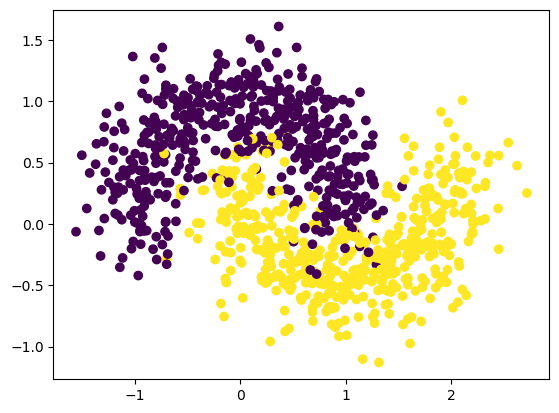

In [6]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=y);

In [7]:
# Turn data into tensors of dtype float
Tensor_X = torch.Tensor(X).type(torch.float).to(device)
Tensor_y = torch.Tensor(y).type(torch.float).to(device)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Tensor_X, Tensor_y, test_size=0.2, random_state=RANDOM_SEED)

In [8]:
X_train.device

device(type='mps', index=0)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [9]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=4, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=1)
        )

    def forward(self, x):
        x_sq = x.pow(2)
        x_aug = torch.cat((x, x_sq), dim=1)
        return self.net(x_aug)

# Instantiate the model
model_0 = MoonModelV0()
model_0.to(device)
model_0

MoonModelV0(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [10]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # Binary Classification, numerically stable version (applies sigmoid inside)

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.Adam(model_0.parameters()) # Works well out-of-the-box

# Experiment
# optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.AdamW(model_0.parameters(), lr=1e-3, weight_decay=1e-2)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [11]:
# What's coming out of our model?

# logits (raw outputs of model)
print("Logits:")
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_train)
print(y_logits[:5].squeeze())

# Prediction probabilities
print("Pred probs:")
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs[:5].squeeze())

# Prediction labels
print("Pred labels:")
y_preds = torch.argmax(y_pred_probs, dim=1)
print(y_preds[:5].squeeze())

Logits:
tensor([-0.2640, -0.3101, -0.3222, -0.3138, -0.2803], device='mps:0')
Pred probs:
tensor([0.4344, 0.4231, 0.4201, 0.4222, 0.4304], device='mps:0')
Pred labels:
tensor([0, 0, 0, 0, 0], device='mps:0')


In [12]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
# !pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="binary", num_classes=2).to(device) # send accuracy function to device
acc_fn

BinaryAccuracy()

In [13]:
## Uncomment this to set the seed
torch.manual_seed(RANDOM_SEED)

# Setup epochs
EPOCHS = 1_000

# Send data to the device
X_train, X_test, y_train, y_test = map(lambda l:l.to(device), [X_train, X_test, y_train, y_test])

# Loop through the data
for epoch in range(EPOCHS):
    ### Training
    model_0.train()

    # 1. Forward pass (logits output)
    y_logits = model_0(X_train)

    # Turn logits into prediction probabilities
    y_preds = torch.sigmoid(y_logits)

    # Turn prediction probabilities into prediction labels
    y_labels = (y_preds > 0.5).long().squeeze()  # shape: (batch_size,)

    # 2. Calculaute the loss
    loss = loss_fn(y_logits.squeeze(), y_train.float()) # loss = compare model raw outputs to desired model outputs

    # Calculate the accuracy
    acc = acc_fn(y_labels, y_train.long()) # the accuracy function needs to compare pred labels (not logits) with actual labels

    # 3. Zero the gradients
    optimizer.zero_grad()

    # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
    loss.backward()
    # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass (to get the logits)
        y_logits_test = model_0(X_test)
        loss_test = loss_fn(y_logits_test.squeeze(), y_test.float())

        # Turn the test logits into prediction labels
        y_labels_test = (torch.sigmoid(y_logits_test) > 0.5).long().squeeze()

        # 2. Calculate the test loss/acc
        loss_test = loss_fn(y_logits_test.squeeze(), y_test.float())
        acc_test = acc_fn(y_labels_test, y_test)

    # Print out what's happening every 100 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: train_loss={loss:.4f}, train_acc={acc:.4f}, test_loss={loss_test:.4f}, test_acc={acc_test:.4f}")

Epoch 0: train_loss=0.6979, train_acc=0.5000, test_loss=0.6942, test_acc=0.5000
Epoch 10: train_loss=0.6636, train_acc=0.5800, test_loss=0.6638, test_acc=0.6300
Epoch 20: train_loss=0.6362, train_acc=0.7337, test_loss=0.6391, test_acc=0.7250
Epoch 30: train_loss=0.6077, train_acc=0.8225, test_loss=0.6134, test_acc=0.7750
Epoch 40: train_loss=0.5771, train_acc=0.8288, test_loss=0.5861, test_acc=0.7700
Epoch 50: train_loss=0.5449, train_acc=0.8300, test_loss=0.5567, test_acc=0.7850
Epoch 60: train_loss=0.5113, train_acc=0.8400, test_loss=0.5250, test_acc=0.7900
Epoch 70: train_loss=0.4773, train_acc=0.8450, test_loss=0.4923, test_acc=0.8200
Epoch 80: train_loss=0.4440, train_acc=0.8450, test_loss=0.4597, test_acc=0.8100
Epoch 90: train_loss=0.4130, train_acc=0.8487, test_loss=0.4295, test_acc=0.8150
Epoch 100: train_loss=0.3855, train_acc=0.8550, test_loss=0.4025, test_acc=0.8250
Epoch 110: train_loss=0.3623, train_acc=0.8550, test_loss=0.3788, test_acc=0.8200
Epoch 120: train_loss=0.343

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [28]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

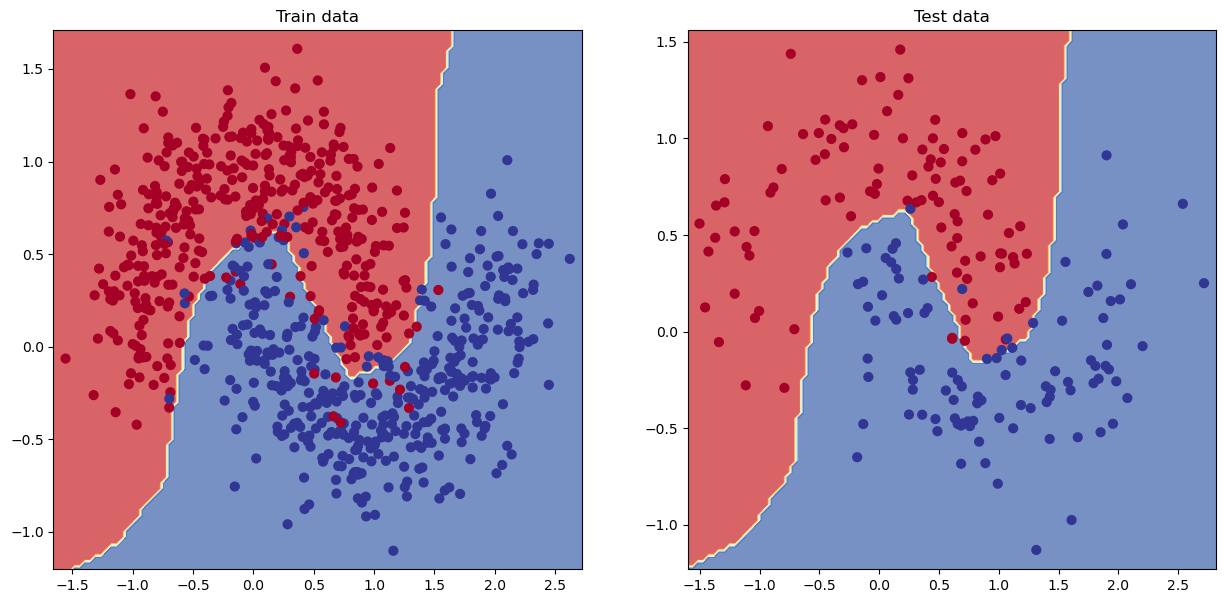

In [15]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Train data")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test data")
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

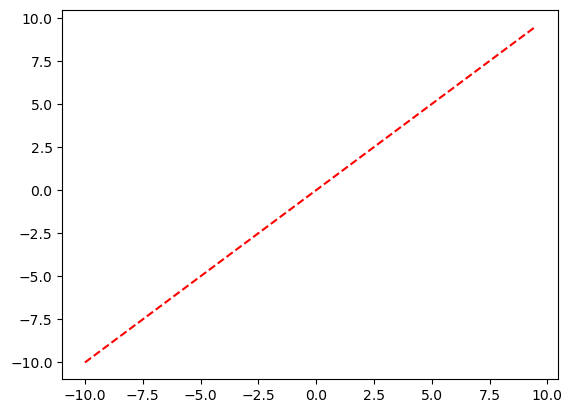

In [16]:
# Create a straight line tensor
line = torch.arange(-10, 10, 0.5)
plt.plot(line, line, "--", color="r");

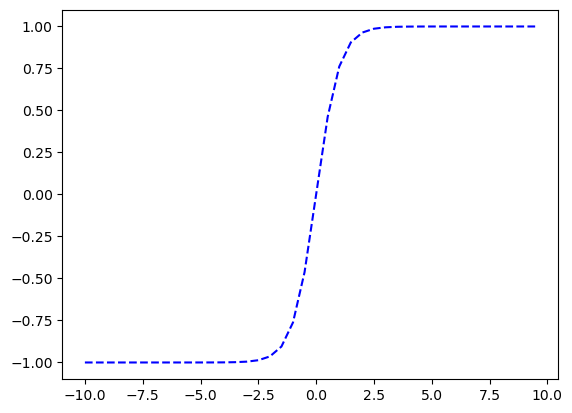

In [17]:
# Test torch.tanh() on the tensor and plot it
plt.plot(line, torch.tanh(line), "--", color="b");

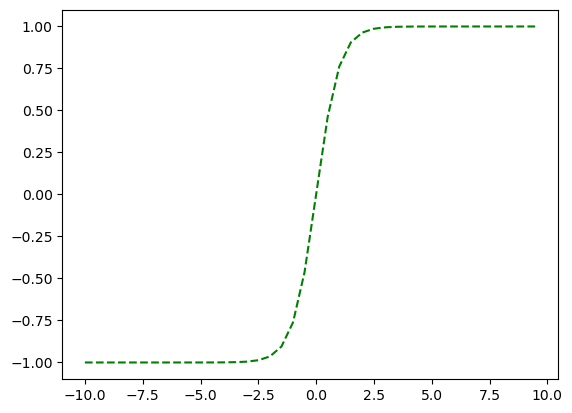

In [18]:
# Replicate torch.tanh() and plot it
def tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
plt.plot(line, tanh(line), "--", color="g");

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

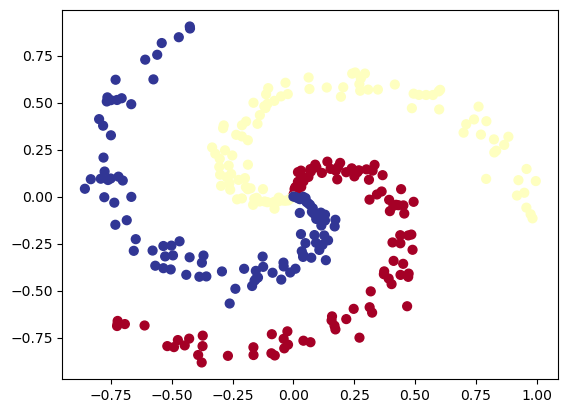

In [1]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [20]:
# Turn data into tensors
import torch
from torch import nn

# Prepare device-agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu"))

X = torch.Tensor(X).type(torch.float) # features as float32
y = torch.Tensor(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [21]:
# Let's calculuate the accuracy for when we fit our model
# !pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [22]:
# Create model by subclassing nn.Module
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=4, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=4)
        )
    def forward(self, x):
        x_sq = x.pow(2)
        x_aug = torch.cat((x, x_sq), dim=1)
        return self.net(x_aug)


# Instantiate model and send it to device
model_1 = SpiralModel()
model_1.to(device)

SpiralModel(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [23]:
# Setup data to be device agnostic
X_train, X_test, y_train, y_test = map(lambda l:l.to(device), (X_train, X_test, y_train, y_test))

# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
with torch.inference_mode():
    y_logits = model_1(X_train)
print(y_logits[:10].squeeze())

print("Pred probs:")
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[:10])

print("Pred labels:")
pred_labels = y_pred_probs.argmax(dim=1)
print(pred_labels[:10])

Logits:
tensor([[-0.0692,  0.0358,  0.0358,  0.2992],
        [-0.0600,  0.0692,  0.0606,  0.3285],
        [-0.0739,  0.0232,  0.0232,  0.2845],
        [-0.0661,  0.0903,  0.0516,  0.3187],
        [-0.0696,  0.0825,  0.0477,  0.3084],
        [-0.0722,  0.0491,  0.0330,  0.2944],
        [-0.0734,  0.0388,  0.0285,  0.2895],
        [-0.0749, -0.0244,  0.0048,  0.2696],
        [-0.0617,  0.0779,  0.0555,  0.3215],
        [-0.0661,  0.0904,  0.0517,  0.3191]], device='mps:0')
Pred probs:
tensor([[0.2143, 0.2380, 0.2380, 0.3097],
        [0.2109, 0.2400, 0.2380, 0.3111],
        [0.2158, 0.2377, 0.2378, 0.3087],
        [0.2099, 0.2455, 0.2361, 0.3085],
        [0.2106, 0.2452, 0.2368, 0.3074],
        [0.2135, 0.2411, 0.2372, 0.3081],
        [0.2144, 0.2399, 0.2374, 0.3083],
        [0.2200, 0.2314, 0.2382, 0.3104],
        [0.2109, 0.2425, 0.2371, 0.3094],
        [0.2099, 0.2455, 0.2361, 0.3085]], device='mps:0')
Pred labels:
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='mps:0'

In [24]:
from torch import optim

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

In [25]:
y_train.shape

torch.Size([240])

In [26]:
# Build a training loop for the model
EPOCHS = 1_000

X_train, X_test, y_train, y_test = map(lambda l:l.to(device), (X_train, X_test, y_train, y_test))

# Loop over data
for epoch in range(EPOCHS):
    ## Training
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred_labels = y_pred_probs.argmax(dim=1)

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train.long())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ## Testing
    if epoch % 10 == 0:
        with torch.inference_mode():
            # 1. Forward pass
            y_logits = model_1(X_test)

            # 2. Caculate loss and acc
            loss = loss_fn(y_logits, y_test.long())
            acc = acc_fn(y_logits, y_test)
        # Print out what's happening every 100 epochs
        print(f"Epoch {epoch}: loss={loss:.4f}, acc={acc:.4f}")

Epoch 0: loss=1.4700, acc=0.0000
Epoch 10: loss=1.4377, acc=0.0000
Epoch 20: loss=1.4109, acc=0.2667
Epoch 30: loss=1.3808, acc=0.2667
Epoch 40: loss=1.3466, acc=0.2667
Epoch 50: loss=1.3080, acc=0.2667
Epoch 60: loss=1.2658, acc=0.2667
Epoch 70: loss=1.2210, acc=0.2667
Epoch 80: loss=1.1771, acc=0.2667
Epoch 90: loss=1.1384, acc=0.4167
Epoch 100: loss=1.1070, acc=0.4167
Epoch 110: loss=1.0810, acc=0.4167
Epoch 120: loss=1.0543, acc=0.4167
Epoch 130: loss=1.0207, acc=0.4500
Epoch 140: loss=0.9862, acc=0.4667
Epoch 150: loss=0.9518, acc=0.4667
Epoch 160: loss=0.9162, acc=0.4667
Epoch 170: loss=0.8817, acc=0.4500
Epoch 180: loss=0.8490, acc=0.4333
Epoch 190: loss=0.8193, acc=0.4667
Epoch 200: loss=0.7919, acc=0.4667
Epoch 210: loss=0.7663, acc=0.4833
Epoch 220: loss=0.7423, acc=0.5500
Epoch 230: loss=0.7197, acc=0.5833
Epoch 240: loss=0.6972, acc=0.5833
Epoch 250: loss=0.6746, acc=0.5833
Epoch 260: loss=0.6509, acc=0.5667
Epoch 270: loss=0.6263, acc=0.5667
Epoch 280: loss=0.6020, acc=0.6

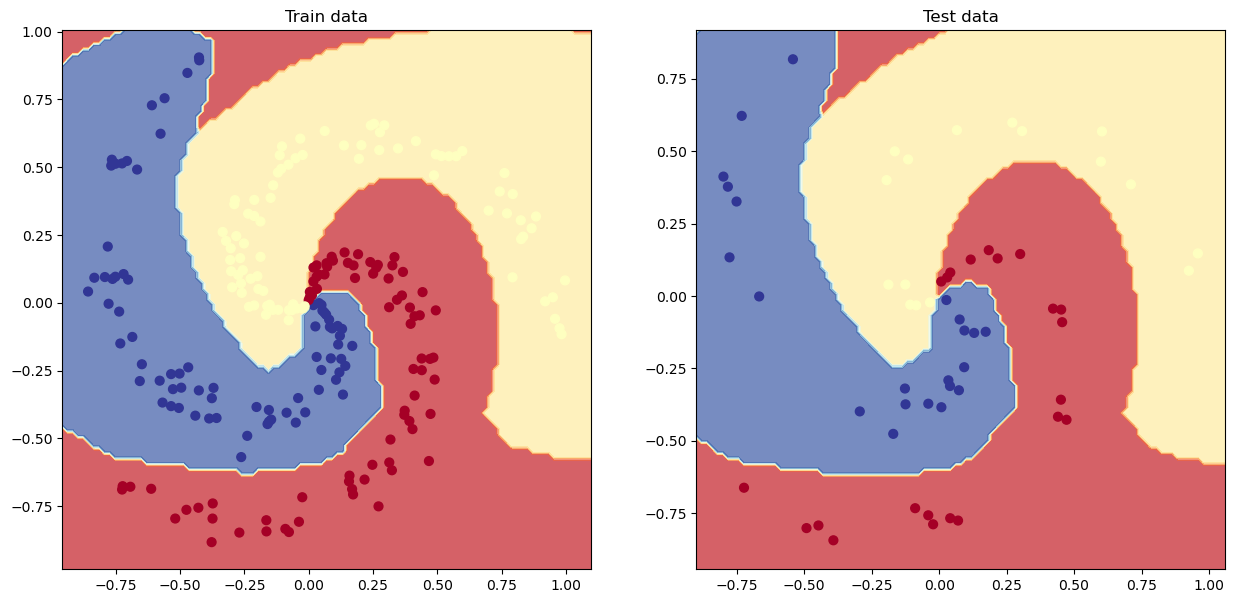

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Train data")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test data")
plot_decision_boundary(model_1, X_test, y_test)